# Overview

The primary goal of this project is to make Go-No-Go decisions on various heating projects in a house with hydronic heat distribution.   The decision will be based on discounted cashflow analysis, based on each project's estimated annual costs and electricity savings.

The analysis is therefore focused on developing models to determine typical electrical consumption savings for a handful of conservation and heat source projects.

The project has the following structure:

#### 1) Heating load model

Based on hourly electrical consumption and weather data from 2015-2018, develop a generally applicable heating load model for the house.

#### 2) Device / Measure models

Based on whatever data is available, including the heating load model above, determine typical annual consumption savings that might be realized from various energy projects.

#### 3) Individual Measure Discounted Cashflow Analysis

Based on budget capital and ongoing cost estimates, perform a discounted cashflow analysis on each measure.  

#### 4) Combinatorical DCA

Time permitting, evaluate combinations of projects.

# Models 
We are attempting to model the house's behaviour in response to its environment, and the combinatorial influence of several heat source models, some of which are *also* influenced by the environment.

### Constraints
  - Hourly irradiance data only available to 2014
  - Hourly electrical consumption data only available since 2015
  - Modelling done in Jupyter/Pandas as a learning exercise.  
    - Pandas/Numpy is very fast in row and column matrix operations 
    - It is slow in iterative operations
    - We must avoid autocorrelated operations (memory) as much as possible

### Intent
We will build a data structure that reflects the hourly state of the house.  Combinations of sequential models will operate on the house to estimate its response in terms of heating load and cost.

The solar collector models are important, and we have no current irradiance data.  Our first task is therefore to create a heating model of the house that allows us to estimate the heating load as a function of OAT during the years in which we *do* have irradiance data.  This is much easier to do accurately than estimating irradiance during years when we have real consumption data.

### House state model  
The goal of the house state is to record the condition of the house at every hour through the study period.  This will allow multiple heating devices to act on the house in succession.

We will track the following state elements.  All energy elements are tracked in kWh/h, and referred to interchangeably with average hourly power.  Temperatures are in C.

  - **RT**: Interior / Room Temperature
  - **RTSP**: Interior temperature setpoint (target temperature)
  - **hload**: actual heating load
  - **rload**: residual heating load
  - **prload**: previous rload (before running current model)
  - **bcons**: BAU (Business-As-Usual) total consumption
  - **cons**: Actual total consumption
  - **exheat**: excess heat produced in this hour
  - **ttank**: Storage tank temperature (if tank exists)


### Environment Model
Key environmental factors used by the house state and the various heating device models are:
  - OAT (Outside Air Temperature)
  - Irradiance and sun position
  
Other environmental factors that we have, but which are not presently being used are:  
  - Wind and windchill
  - Dewpoint and humidex
  - Barometric pressure
  
### Heating device models
Each heating device is modelled as a single function.  It takes the house and environment models as inputs, and may accept tuning parameters.  It outputs a modified house model.

We have the following devices in ascending order of operating cost.  The intention is that the house will attempt to satisfy its heating load by applying one or more of these devices in the following order:

  - BAU state - sets RTSP to 22, tank temperature
  - Night setback - changes RTSP at night
  - LE solar - reduces unserved (residual) heating load
  - HE solar - ditto
  - wood boiler - ditto
  - tank - accepts unused heat from devices, pays back later, cools off
  - heat pump - provides heat within limits
  - electric boiler - always present, but last resort


## Weather data

Weather data is from the **Nanaimo/Cassidy Airport YCD**, 13km away from site.  Entrance Island at the northern tip of Gabriola Island is slightly closer at 11km, but it was rejected due to marine winter temperature measurements being significantly higher than those observed on land.  

NB that:

  - BC Hydro consumption data is for the 1-hour interval following the weather measurement.  It is reported in kWh/h, which we will use interchangeably with kW.
  - DST: WX timestamps are in LST.  Hydro data timestamps are also assumed to be in local time, although BC Hydro has not confirmed this.
  - There are some missing observations in the weather data, but usually only for an hour or two, so we can interpolate pretty well.
  
## HVAC Glossary
  - BAU - Business As Usual (unimproved state)
  - RT - Room Temperature (Interior)
  - RTSP - RT Setpoint (IE, thermostat setting)
  - OAT - Outside Air Temperature
  - WX - Weather

## HE Solar

These are black collector tubes inside larger clear tubes which are evacuated.  The vacuum tubes insulate the collector, so you get to keep more of the heat.  They're marketed as being great for Canada, but I don't see many of them in Coastal BC.

Unfortunately, the only local source of irradiance data is the CWEEDS database, which ends in 2014 -- before my consumption data begins.  My best path forward is to apply my heating load model to the irradiance years to see how effective solar would've been in the past.

Here are some figures for collector efficiency as a function of DT (collector - OAT), collected from 
https://www.builditsolar.com/References/Calculators/Collector/ColEfic.htm
  - Unglazed: 83% - 1.07 %/degC
  - Plate: 74% - 0.32 %/degC
  - VacTube: 53% - 0.12 %/degC

## Example setup
Latitude51 sells a 30-pipe unit (1.8m x 58mm x 30 = 3.13 m^2) for $1767 shipped, = $564/m^2.  We'll base this calculation on the 30-pipe unit.

## Issues:
  - No snow cover data.  OK to neglect in Nanaimo, very rare to have useful irradiance while there's snowcover.
  - Based on normal irradiance; This is OK for traverse with round tubes, but need to de-rate for azimuth.

## Collector heat collection model
### Efficacy
A tube collector's efficacy doesn't change based on the sun's azimuth (the bearing to the sun).  Altitude (elevation from the horizon) does change things, though.  So we have to choose a tilt angle.

Optimum tilt angle for flat plate collectors all over the World – A declination dependence formula and comparisons of three solar radiation models
https://www.sciencedirect.com/science/article/pii/S0196890414001265

The Sun’s apparent position and the optimal tilt angle of a solar collector in the northern hemisphere
https://www.sciencedirect.com/science/article/pii/S0038092X09000395
Angle of collector from horizontal:
  - Summer: .91 x lat=44.59
  - Winter: .76 x lat =37.4
  - Average: 41.0
  
However, I ran a numerical optimizer against this model to maximize heat savings -- IE, to maximize the *useful* solar heat captured.  It solved to an angle of 20.6 degrees.  This is surprising, but the maximum solar elevation in Nanaimo during the heating season varies between 17 and 25 degrees from about November to February.  So this value actually seems reasonable.

### Efficiency
Our model for collector efficiency requires a $\Delta T$ versus OAT.  Because we really need a minimum of 35C water to be useful for heating, let's treat our average water temperature ($ \frac{T_{out} + T_{in}}{2} $) = 32.5C.


Text(0.5,0,'Month')

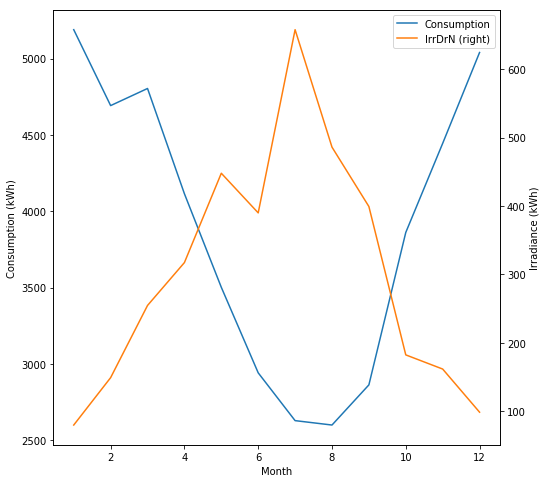

In [4]:
import pandas as pd
import bau
import matplotlib.pyplot as plt

ir = pd.read_pickle("irradiance2014.pickle")

b = bau.BAU(ir)
b.apply()

fig, axe = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

axe.set_ylabel("Consumption (kWh)")
h = ir.bcons.groupby(ir.index.month).sum().plot(ax=axe,label='Consumption',legend=True)
h = ir.IrrDrN.groupby(ir.index.month).sum().plot(ax=axe,secondary_y='IrrDrN',legend=True)
h.set_ylabel('Irradiance (kWh)')
axe.set_xlabel("Month")